In [1]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt

In [2]:

#using single family home prices historical dataset (zillow has a few other options as well to try including w/ condos, Xbedrooms, etc.)
sfh_prices = pd.read_csv("/Users/afrazier/Documents/personal/real_estate/data/single_family_historical.csv")
print(sfh_prices.index.size)

30468


In [3]:
#pre-processing, filter out zipcodes without significant populations
twenty_ten_census_zip_populations = pd.read_csv("data/population_by_zip_2010.csv")
zip_populations = twenty_ten_census_zip_populations.groupby('zipcode')['population'].sum().reset_index()
prices_with_pops = sfh_prices.merge(zip_populations, left_on="RegionName", right_on="zipcode")
print(prices_with_pops.index.size)
#filter to zips with atleast 25K people living there
min_population = 25000
prices_with_pops = prices_with_pops[prices_with_pops.population>min_population]
print(prices_with_pops.index.size)
sfh_prices = prices_with_pops

29906
10347


In [4]:
#melt the date,price into multiple rows instead of one wide table
date_cols = [x for x in sfh_prices.columns if sfh_prices[x].dtype=='float64']
melted_prices = pd.melt(sfh_prices, id_vars=['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName','State', 'City', 'Metro', 'CountyName'], value_vars=date_cols)
melted_prices = melted_prices.rename(columns = {"variable": "date", "value": "price"})
melted_prices.date = pd.to_datetime(melted_prices.date)
# remove years/zips with null prices -> 693977/5044869 (~14%) null prices 
melted_prices = melted_prices[~(melted_prices.price.isnull())]
#calculate monthly changes in price
melted_prices['monthly_price_change'] = melted_prices.sort_values(["RegionName", "date"])['price'].diff()


In [5]:
#add in the year distnace from the last date so we can perform regression on the price
max_date = melted_prices.date.max()
melted_prices['months_difference'] = (melted_prices.date-max_date)/(np.timedelta64(1, 'M'))

#filter to only datapoints from the last 5 years (12*5=16)
#can try other values here as it might be nice to include the 2008 crash as well
melted_prices = melted_prices[melted_prices.months_difference>-60]



In [6]:
#calculate slope, std, and number datapoints
zipcode_slopes = melted_prices.sort_values(["RegionID", "RegionName", "date"]).groupby(["RegionID", "RegionName"]).apply(
            lambda x: linregress(x.months_difference, x['price'])[0]).round()
zipcode_slopes.name = "monthly_price_slope"
zipcode_price_change_stds = melted_prices.groupby(["RegionID", "RegionName"])['monthly_price_change'].std().round()
zipcode_price_change_stds.name = "monthly_price_change_std"
zipcode_datapoints = melted_prices.groupby(["RegionID", "RegionName"])['price'].size()
zipcode_datapoints.name = "total_data_points"


In [7]:
zipcode_current_avg_price = melted_prices.sort_values(["RegionID", "RegionName", "date"]).groupby(["RegionID", "RegionName"])["RegionID", 'RegionName', 'price'].tail(1).set_index(["RegionID", "RegionName"])
zipcode_current_avg_price.rename(columns = {"price": "last_avg_price"}, inplace=True)


<ipython-input-7-8a4d9baacfed>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  zipcode_current_avg_price = melted_prices.sort_values(["RegionID", "RegionName", "date"]).groupby(["RegionID", "RegionName"])["RegionID", 'RegionName', 'price'].tail(1).set_index(["RegionID", "RegionName"])


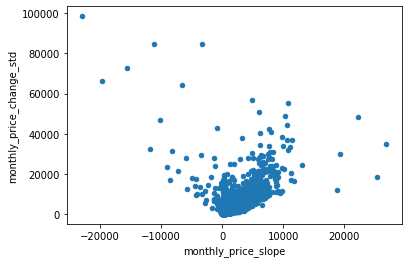

In [8]:
ten_year_slope_and_stds = pd.concat([zipcode_slopes, zipcode_price_change_stds, zipcode_datapoints, zipcode_current_avg_price], axis=1)
#lets filter to zipcodes with atleast 3 years of data?
ten_year_slope_and_stds =  ten_year_slope_and_stds[ten_year_slope_and_stds.total_data_points>=36]
ten_year_slope_and_stds.plot.scatter(x="monthly_price_slope", y="monthly_price_change_std")

In [9]:
ten_year_slope_and_stds['sharpe_ratios'] =  ten_year_slope_and_stds['monthly_price_slope']/ten_year_slope_and_stds['monthly_price_change_std']

#Lets Just look at zip codes with >2k a month
growth = ten_year_slope_and_stds[ten_year_slope_and_stds.monthly_price_slope>1000]
growth.sort_values('sharpe_ratios', ascending=False)[:25]

,,monthly_price_slope,monthly_price_change_std,total_data_points,last_avg_price,sharpe_ratios
RegionID,RegionName,,,,,
82261,55411,1540.0,694.0,61,232129.0,2.219020
65791,19124,1103.0,525.0,61,153449.0,2.100952
94589,84532,2682.0,1287.0,61,498172.0,2.083916
94399,84032,3636.0,1755.0,61,657653.0,2.071795
99930,98632,2362.0,1141.0,61,347881.0,2.070114
99926,98626,2481.0,1269.0,61,346470.0,1.955083
72445,33142,2404.0,1266.0,61,309359.0,1.898894
71034,30314,3521.0,1865.0,61,275312.0,1.887936
100135,99163,1703.0,904.0,61,417595.0,1.883850


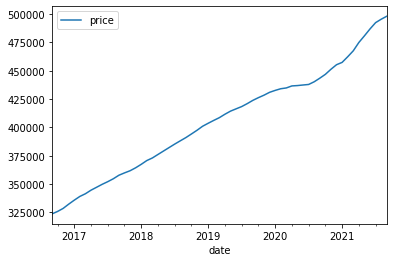

In [10]:
#interesting zipcodes 
# with slower appreciation but low std (risk)
#1. 84532 - Moab, UT (arches?!)
#2. 84032 - Wasatch County, Utah
#3. 98632 - Longview, WA 98632


#with larger appreciaion
#and still relatively low risk
#1. 91108 - Pasadena, CA  -> no houses in this specific zip?
#2. 90211 - Beverly Hills, CA 90211

melted_prices[melted_prices.RegionName==84532][['date', 'price']].set_index("date").plot()


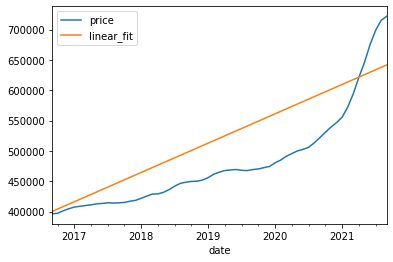

In [11]:
#why no austin, nash in these lists? which filter is removing them?
#east side has 4K appreciation with lowish std. -> 0.57 sharpe

# 78702, east side austin
ten_year_slope_and_stds[ten_year_slope_and_stds.index==78702]

fig, ax = plt.subplots()


price_plot = melted_prices[melted_prices.RegionName==78702][['date', 'price']].set_index("date").plot(ax=ax, label="actual")
linear_fit_x = price_plot.lines[0].get_xdata()
linear_fit_y = np.arange(400000,400000+4030.0*len(linear_fit_x), 4030)
# linear_fit_x = [x.to_timestamp() for x in linear_fit_x]
ax.plot(linear_fit_x, linear_fit_y, label="linear_fit")
plt.legend()
plt.show()

In [12]:

#austin has much higher appreciation in the last few years. can we build a slightly better forecast than linear?
#looking into some ETS and other slightly more advanced forecasting methods.
#what about zillows own forecasting data?

zillow_forcasts = pd.read_csv("data/price_forecasts.csv")

#lets grab the zip forecasts
zip_forcasts = zillow_forcasts[zillow_forcasts.Region=="Zip"]
zip_forcasts.RegionName = zip_forcasts.RegionName.astype("int64")


#merge these percentage changes with existing historical analysis
print(ten_year_slope_and_stds.index.size)
print(zip_forcasts.index.size)
historical_and_forecast = ten_year_slope_and_stds.reset_index().merge(zip_forcasts, left_on="RegionName", right_on="RegionName", how="left")
print(historical_and_forecast.index.size)
#losing around 1K zipcodes here?

10297
20873
10297


/usr/local/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [13]:
historical_and_forecast['zillow_1yr_revenue_forecast'] = historical_and_forecast.last_avg_price*(historical_and_forecast.ForecastYoYPctChange*0.01)
historical_and_forecast.sort_values("ForecastYoYPctChange", ascending=False)[:25]

#lets filter to zips with >50K growth in the next year and sharpe ratio >1
stable_growth = historical_and_forecast[(historical_and_forecast.zillow_1yr_revenue_forecast>50000) & (historical_and_forecast.sharpe_ratios>1)]
stable_growth.sort_values("ForecastYoYPctChange", ascending=False)[:25]


# historical_and_forecast[historical_and_forecast.RegionName==78702]

,RegionID,RegionName,monthly_price_slope,monthly_price_change_std,total_data_points,last_avg_price,sharpe_ratios,Region,StateName,CountyName,CityName,ForecastedDate,ForecastYoYPctChange,zillow_1yr_revenue_forecast
3088,71034,30314,3521.0,1865.0,61,275312.0,1.887936,Zip,GA,Fulton County,Atlanta,2022-09-30,32.7,90027.024
3703,72708,33605,2011.0,1673.0,61,228866.0,1.202032,Zip,FL,Hillsborough County,Tampa,2022-09-30,30.4,69575.264
3707,72713,33610,1719.0,1570.0,61,229995.0,1.094904,Zip,FL,Hillsborough County,Tampa,2022-09-30,29.2,67158.540
3716,72722,33619,1675.0,1521.0,61,229162.0,1.101249,Zip,FL,Hillsborough County,Palm River-Clair Mel,2022-09-30,29.1,66686.142
3084,71030,30310,3190.0,2332.0,61,316685.0,1.367925,Zip,GA,Fulton County,Atlanta,2022-09-30,29.0,91838.650
3735,72774,33711,1758.0,1377.0,61,227277.0,1.276688,Zip,FL,Pinellas County,Saint Petersburg,2022-09-30,28.5,64773.945
3085,71031,30311,2840.0,1827.0,61,286450.0,1.554461,Zip,GA,Fulton County,Atlanta,2022-09-30,27.9,79919.550
3761,72830,33805,1392.0,1289.0,61,195887.0,1.079907,Zip,FL,Polk County,Lakeland,2022-09-30,27.0,52889.490
3759,72826,33801,1347.0,1226.0,61,199212.0,1.098695,Zip,FL,Polk County,Lakeland,2022-09-30,26.9,53588.028
3089,71035,30315,2365.0,1587.0,61,247092.0,1.490233,Zip,GA,Fulton County,Atlanta,2022-09-30,26.5,65479.380


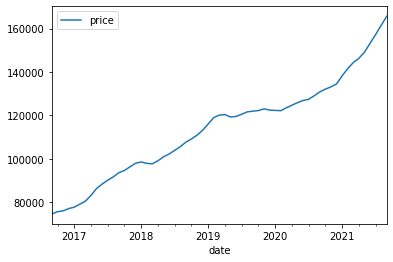

In [41]:
#interesting, zillow predicts fulton county atlanta to have highest increase in the next year?
melted_prices[melted_prices.RegionName==32922][['date', 'price']].set_index("date").plot()


In [15]:
#requirements -> good sharpe ratio of risk to return. ideally >1

# forecasted annual property value increase of >20K (and >10%)
#have a basic linear model but might want to look into other things here


#things to add
# population is growing at decent rate
# major school, grocery store, and hospital within 10-20 miles of home
# Average salary/income shows a positive trend for this place too! 


# rental yield is strong. ie, i can make 1% of house cost in rent each year? (check vs BRRRRR book rule)
# or I can make X dollars in rent each year. 

In [16]:
#only have 2093 zipcodes with rent; need additional sources
rental_yields = pd.read_csv("data/updated_rental_yields.csv")

In [17]:
# rental_yields.MsaName.drop_duplicates().size
# historical_and_forecast.CityName.drop_duplicates().size#.RegionName.drop_duplicates().size


def cleanup_zips(df):
    df.RegionName = df.RegionName.astype("string")
    #filter out the few zips with only 3 digits
    df = df.loc[df.RegionName.str.len()>=4] 
    #add in a leading 0 for zips with only 4 digits
    df.loc[df.RegionName.str.len()==4, 'RegionName'] = ('0' + df[df.RegionName.str.len()==4].RegionName.astype("str"))
    #better logic for matching zips on the first 3 numbers (adding in 0 for zips with only 4 digits)
    #then finding the zip with min abs value between remaining digits
    df['first_three_zip_digits'] = df.RegionName.str[0:3]
    df['last_two_zip_digits'] = df.RegionName.str[3:5].astype("int64")
    return df




historical_and_forecast = cleanup_zips(historical_and_forecast)


/usr/local/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
<ipython-input-17-d9591a0ee767>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['first_three_zip_digits'] = df.RegionName.str[0:3]
<ipython-input-17-d9591a0ee767>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [18]:
#eventually we can add in the rate of rent increases to project rental yields in the future.
#for now lets just see how much zipcodes are renting at as of last month of data (then compare to housing costs)
last_month_rental_yields = rental_yields[['RegionID', 'RegionName', '2021-09']]
last_month_rental_yields.rename(columns = {'2021-09': "monthly_rent_approx"}, inplace=True)

last_month_rental_yields = cleanup_zips(last_month_rental_yields)


/usr/local/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/usr/local/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [23]:
#lets try and join with the closest zip code (should be same zipcode if present)

rent_and_forecasts = historical_and_forecast.merge(last_month_rental_yields, how="inner", on="first_three_zip_digits")
rent_and_forecasts['zip_abs_diff'] = abs(rent_and_forecasts.last_two_zip_digits_x-rent_and_forecasts.last_two_zip_digits_y)
closest_zips = rent_and_forecasts.groupby(['RegionName_x'])['zip_abs_diff'].idxmin()


In [25]:
closest_zip_data = rent_and_forecasts.loc[closest_zips]
assert(closest_zip_data.loc[closest_zip_data.RegionName_x=='10016', 'RegionName_y'].values[0]=='10016')


In [28]:
#okay now we have rental data for much more zips but some of the zips rentals may be a bit of a stretch (might need to throw some out with zip_abs_diff > X)
# 6043 of the initial 10294 zips have a matching 3 letter start of their zipcode
print(historical_and_forecast.index.size)
print(closest_zip_data.index.size)
closest_zip_data[['RegionName_x', 'RegionName_y', 'zip_abs_diff']].sort_values("zip_abs_diff", ascending=False)


10294
6043


,RegionName_x,RegionName_y,zip_abs_diff
9939,21797,21702,95
27422,40299,40204,95
9937,21795,21702,93
9935,21793,21702,91
27421,40291,40204,87
...,...,...,...
32244,60202,60202,0
32245,60302,60302,0
32248,60402,60402,0
32261,60411,60411,0


In [29]:

# print(historical_and_forecast.index.size)
# apprecation_and_rent = historical_and_forecast.merge(last_month_rental_yields, on="RegionID", how="left")
# print(apprecation_and_rent.index.size)
# we only have rental yields for ~1/5 of the zipcodes?
# maybe we should use the city ones instead? to get more data values, and then apply zipcodes when we can?

#try merging primary on zip and then use city as backup for places we cant get a zip. 

In [30]:
# rental data includes multifamily but prices/apprecaiton data is only SFHs so 
# this calculation of rental yield might be a bit off but atleast it should be skewed for all zipcodes
# and therfore still work as a way to sort them by renatl yields

#overall rental yields may be less though. try and check a few locations to see if the values are close and if we can 
#do any transformations to help



closest_zip_data['approx_rental_yield'] = closest_zip_data.monthly_rent_approx/closest_zip_data.last_avg_price
closest_zip_data.sort_values("approx_rental_yield", ascending=False)[:25]

,RegionID_x,RegionName_x,monthly_price_slope,monthly_price_change_std,total_data_points,last_avg_price,sharpe_ratios,Region,StateName,CountyName,...,ForecastYoYPctChange,zillow_1yr_revenue_forecast,first_three_zip_digits,last_two_zip_digits_x,RegionID_y,RegionName_y,monthly_rent_approx,last_two_zip_digits_y,zip_abs_diff,approx_rental_yield
5674,62298,11951,1861.0,3210.0,61,305374.0,0.579751,Zip,NY,Suffolk County,...,15.1,46111.474,119,51,62287,11937,26444.0,37,14,0.086595
5671,62297,11950,2486.0,2156.0,61,370827.0,1.153061,Zip,NY,Suffolk County,...,12.9,47836.683,119,50,62287,11937,26444.0,37,13,0.071311
5684,62313,11967,2339.0,2101.0,61,399912.0,1.113279,Zip,NY,Suffolk County,...,12.5,49989.000,119,67,62323,11978,25756.0,78,11,0.064404
5677,62300,11953,2087.0,2420.0,61,441358.0,0.862397,Zip,NY,Suffolk County,...,12.2,53845.676,119,53,62287,11937,26444.0,37,16,0.059915
5681,62308,11961,1965.0,2301.0,61,443945.0,0.853977,Zip,NY,Suffolk County,...,11.4,50609.730,119,61,62323,11978,25756.0,78,17,0.058016
5668,62296,11949,2319.0,3385.0,61,627115.0,0.685081,Zip,NY,Suffolk County,...,11.3,70863.995,119,49,62287,11937,26444.0,37,12,0.042168
26596,73377,35207,268.0,629.0,61,43129.0,0.426073,Zip,AL,Jefferson County,...,13.1,5649.899,352,7,73375,35205,1802.0,5,2,0.041782
11319,69394,27536,169.0,266.0,61,53795.0,0.635338,NaN,NaN,NaN,...,NaN,NaN,275,36,69397,27540,1962.0,40,4,0.036472
5665,62293,11946,3438.0,4575.0,61,756828.0,0.751475,Zip,NY,Suffolk County,...,12.3,93089.844,119,46,62287,11937,26444.0,37,9,0.034941
29304,79059,48204,405.0,555.0,61,41513.0,0.729730,Zip,MI,Wayne County,...,17.1,7098.723,482,4,79075,48220,1439.0,20,16,0.034664


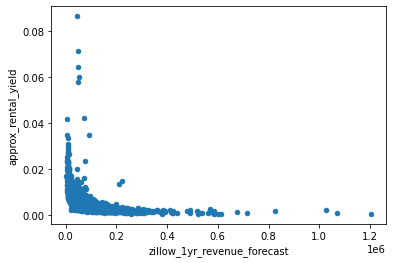

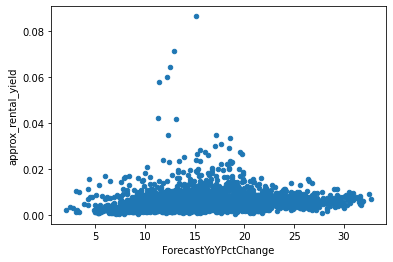

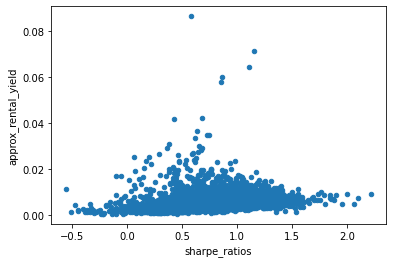

In [35]:
#rental yield on y axis and 1 year appreciation forecast on the x
#trade off for appreciation vs rent.

closest_zip_data.plot.scatter(x="zillow_1yr_revenue_forecast", y="approx_rental_yield")

closest_zip_data.plot.scatter(x="ForecastYoYPctChange", y="approx_rental_yield")

closest_zip_data.plot.scatter(x="sharpe_ratios", y="approx_rental_yield")

In [52]:
alexs_shortlist = closest_zip_data[(closest_zip_data.approx_rental_yield>0.01) & (closest_zip_data.sharpe_ratios>0.5) & (closest_zip_data.last_avg_price<600000) & (closest_zip_data.last_avg_price>200000)].sort_values("ForecastYoYPctChange", ascending=False)
alexs_shortlist#.to_csv("alexs_shortlist.csv", index=False)

,RegionID_x,RegionName_x,monthly_price_slope,monthly_price_change_std,total_data_points,last_avg_price,sharpe_ratios,Region,StateName,CountyName,...,ForecastYoYPctChange,zillow_1yr_revenue_forecast,first_three_zip_digits,last_two_zip_digits_x,RegionID_y,RegionName_y,monthly_rent_approx,last_two_zip_digits_y,zip_abs_diff,approx_rental_yield
23932,72657,33523,1344.0,1230.0,61,200402.0,1.092683,Zip,FL,Hernando County,...,26.3,52705.726,335,23,72663,33534,2080.0,34,11,0.010379
39493,91255,76110,1282.0,1213.0,61,214957.0,1.056884,Zip,TX,Tarrant County,...,22.1,47505.497,761,10,91255,76110,2703.0,10,0,0.012575
19566,72312,32935,1191.0,1528.0,61,242586.0,0.779450,Zip,FL,Brevard County,...,22.1,53611.506,329,35,72309,32931,2599.0,31,4,0.010714
39300,91234,76085,1748.0,2520.0,61,376670.0,0.693651,Zip,TX,Parker County,...,20.7,77970.690,760,85,91238,76092,4515.0,92,7,0.011987
12147,69759,28168,1051.0,1289.0,61,212417.0,0.815361,Zip,NC,Lincoln County,...,20.6,43757.902,281,68,69762,28173,2345.0,73,5,0.011040
39345,91237,76088,1978.0,2691.0,61,397465.0,0.735043,Zip,TX,Parker County,...,20.5,81480.325,760,88,91238,76092,4515.0,92,4,0.011359
39330,91236,76087,1583.0,2422.0,61,388649.0,0.653592,Zip,TX,Parker County,...,20.0,77729.800,760,87,91238,76092,4515.0,92,5,0.011617
39285,91232,76082,1570.0,1796.0,61,314112.0,0.874165,Zip,TX,Parker County,...,19.7,61880.064,760,82,91238,76092,4515.0,92,10,0.014374
39315,91235,76086,1111.0,1169.0,61,224897.0,0.950385,Zip,TX,Parker County,...,19.4,43630.018,760,86,91238,76092,4515.0,92,6,0.020076
22841,72582,33415,1508.0,1454.0,61,285512.0,1.037139,Zip,FL,Palm Beach County,...,19.4,55389.328,334,15,72581,33414,3289.0,14,1,0.011520


In [ ]:
#interesting places to look to buy:

# currently going down the list and checking out each zip on wikepedia and google maps
# on 90201


#FL
    #1. Melbourne, FL 32935
    #2. 33523 (Dade) ? 
    #3. 33415, 33417 (palm beach)


#TX
    #zips near fortworth, tx (dallas)
    #1. 76110, 
    #1. 76086, 76085, 76088, 76087, 76082 weatherford tx
    #2. 


#NC
    #1. 28168 ??
    #2. 28147 (charlotte/salisbury)
    

#TN

    #1. 37040, 37042 (clarksville) 5th largest city in TN


#CA

    #1. 92311 (barstow)
    #2. 92274, 92254 (near joshua tree?)
    

#NY

    #1. 11951 (mastic beach)